In [1]:
#meta 12/13/2020 Submit Daniel's code to verify submission works.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from fastai.vision.all import *

# Introduction & Obtaining Pretrained Models

I am following [this notebook](https://www.kaggle.com/tanlikesmath/cassava-classification-eda-fastai-starter) and [this notebook](https://www.kaggle.com/muellerzr/cassava-fastai-starter). The goal is to produce a simple working submission using fastai. This will *not* include EDA or more than a passing attempt at model selection/tuning. This guide differs from the linked notebooks because it includes more detailed instructions for finding and downloading pre-trained PyTorch model weights and using them with the notebook set for offline use.

One note: for this competition, the notebook cannot have Internet access, so we need to make sure any pre-trained model weights are loaded in advance. To do so, we download the `.pth` files and then add them using the "add data" button in the sidebar on the right. We also need to make sure fastai knows where to find these files; this process is detailed below.

You can find the URLs for the various models [here](https://github.com/pytorch/vision/tree/master/torchvision/models). For example, if you're interested in `resnet50`, open the [resnet.py](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) file. The `model_urls` variable shows the URLs for the various resnet models; the URL for resnet50 is https://download.pytorch.org/models/resnet50-19c8e357.pth.

# Data Setup

In [3]:
path = Path('../input/cassava-leaf-disease-classification')
train_df = pd.read_csv(path/'train.csv')
train_df['image_id'] = train_df['image_id'].apply(lambda x: f'train_images/{x}')
train_df.head()

,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3


## Making Labels More Interpretable

In [4]:
idx2lbl = {0:"Cassava Bacterial Blight (CBB)",
          1:"Cassava Brown Streak Disease (CBSD)",
          2:"Cassava Green Mottle (CGM)",
          3:"Cassava Mosaic Disease (CMD)",
          4:"Healthy"}

train_df['label'].replace(idx2lbl, inplace=True)
train_df.head()

,image_id,label
0,train_images/1000015157.jpg,Cassava Bacterial Blight (CBB)
1,train_images/1000201771.jpg,Cassava Mosaic Disease (CMD)
2,train_images/100042118.jpg,Cassava Brown Streak Disease (CBSD)
3,train_images/1000723321.jpg,Cassava Brown Streak Disease (CBSD)
4,train_images/1000812911.jpg,Cassava Mosaic Disease (CMD)


## Building the Datablock

In [5]:
def get_x(row): return path/row['image_id']
def get_y(row): return row['label']

db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = get_x,
                 get_y = get_y,
                 splitter = RandomSplitter(valid_pct=0.2),
                 item_tfms = [Resize(128)], # starting with small images for efficient testing
                 batch_tfms = [RandomResizedCropGPU(224), *aug_transforms(), Normalize.from_stats(*imagenet_stats)])

## DataLoaders

In [6]:
dls = db.dataloaders(train_df, bs=64)

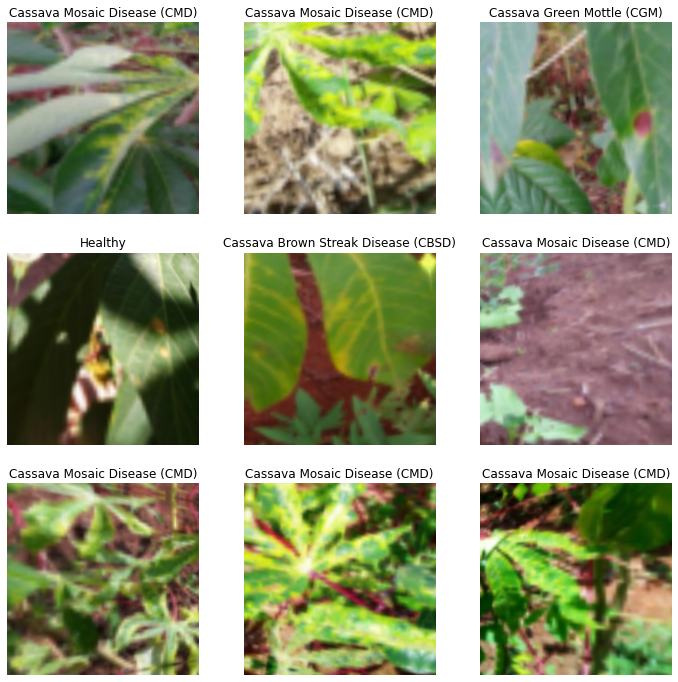

In [7]:
dls.show_batch(figsize=(12,12))

# Train the Model

We're going to start with ResNet 18. We first need to make sure we can find the appropriate model weights. We downloaded the pretrained weights from [here](https://download.pytorch.org/models/resnet18-5c106cde.pth). We now need to make sure fastai can find the weights.

A reminder: You can find the URLs for the various models [here](https://github.com/pytorch/vision/tree/master/torchvision/models). For example, if you're interested in `resnet50`, open the [resnet.py](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) file. The `model_urls` variable shows the URLs for the various resnet models; the URL for resnet50 is https://download.pytorch.org/models/resnet50-19c8e357.pth.

So if you want to use a pretrained model *other than* `resnet18`, the steps are: (1) locate the URL, as noted above; (2) download the `.pth` file; (3) upload the `.pth` file using "Add data" in the sidebar; (4) make fastai aware of the location of the weights, following the procedure in the next cell but copying the desired model; (5) call the desired model in your fastai learner.

In [8]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/pretrained-pytorch/resnet18-5c106cde.pth' '/root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth'

In [9]:
learn = cnn_learner(dls, resnet18, opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

In [10]:
learn.fine_tune(6, freeze_epochs = 3)

epoch,train_loss,valid_loss,accuracy,time
0,2.017921,1.478379,0.490769,04:15
1,1.379989,1.101857,0.667212,03:45
2,1.118283,1.017271,0.698528,03:43


epoch,train_loss,valid_loss,accuracy,time
0,1.044698,0.954920,0.727273,03:45
1,0.928658,0.911049,0.751344,03:47
2,0.880811,0.927574,0.743865,03:48
3,0.852949,0.877565,0.771676,03:52
4,0.831421,0.837702,0.787100,03:54
5,0.815479,0.838316,0.787333,03:49


# Preparing a Submission

In [11]:
# Format submission df in same way as training df
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_copy = sample_df.copy()
sample_copy['image_id'] = sample_copy['image_id'].apply(lambda x: f'test_images/{x}')

test_dl = learn.dls.test_dl(sample_copy)
preds, _ = learn.tta(dl=test_dl) # test-time augmentation can improve accuracy somewhat

sample_df['label'] = preds.argmax(dim=-1).numpy()
sample_df.to_csv('submission.csv',index=False)

In [12]:
sample_df.head()

,image_id,label
0,2216849948.jpg,2
